# Baysian TWFE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_names,years,island_ids,region_codes,region_names,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,...,cohort_2000,years_cohort_2000,cohort_2004,years_cohort_2004,cohort_2011,years_cohort_2011,cohort_2015,years_cohort_2015,cohort_2016,years_cohort_2016
0,鹿久居島,1975,68,33342,日生町,33,46,1,1,2015,...,0,0,0,0,0,0,1,-40,0,0
1,鹿久居島,1980,68,33342,日生町,33,52,1,1,2015,...,0,0,0,0,0,0,1,-35,0,0
2,鹿久居島,1985,68,33342,日生町,33,53,1,1,2015,...,0,0,0,0,0,0,1,-30,0,0
3,鹿久居島,1990,68,33342,日生町,33,54,1,1,2015,...,0,0,0,0,0,0,1,-25,0,0
4,鹿久居島,1995,68,33342,日生町,33,45,1,1,2015,...,0,0,0,0,0,0,1,-20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,戸島,2000,218,38203,宇和島市,38,451,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,戸島,2005,218,38203,宇和島市,38,473,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,戸島,2010,218,38203,宇和島市,38,414,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,戸島,2015,218,38203,宇和島市,38,344,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
population_change_rate = df['population_change_rate']
treatment = df['treatment_group']
passage_of_year = dmatrix('C(passage_of_year) -1', data=df, return_type='dataframe')
islands = dmatrix('C(island_ids) -1', data=df, return_type='dataframe')
years = dmatrix('C(years) -1', data=df, return_type='dataframe')

n_passage_of_year = passage_of_year.shape[1]
n_islands = islands.shape[1]
n_years = years.shape[1]

## TWFE

$$
Y_{it} = \text{TreatmentGroup} + \text{Year}_t + \text{PassageOfYear}
$$

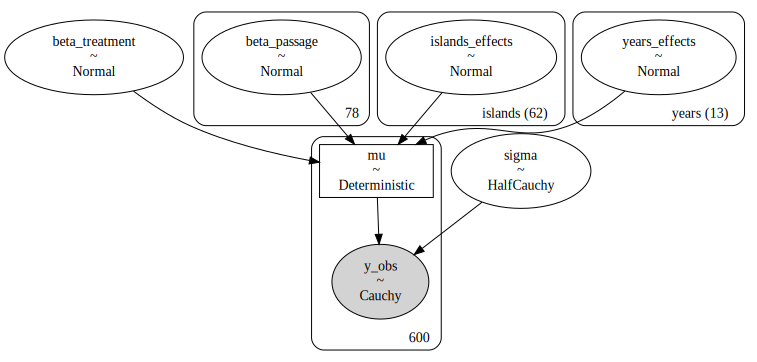

In [5]:
with pm.Model() as model:
    # Data

    # Priors
    beta_treatment = pm.Normal('beta_treatment', mu=0, sigma=100)
    beta_passage = pm.Normal('beta_passage', mu=0, sigma=100, shape=n_passage_of_year)
    islands_effects = pm.Normal('islands_effects', mu=0, sigma=100, shape=n_islands, dims='islands')
    years_effects = pm.Normal('years_effects', mu=0, sigma=100, shape=n_years, dims='years')
    sigma = pm.HalfCauchy('sigma', beta=1e6)

    # expectation
    mu = pm.Deterministic(
        'mu',
        beta_treatment * treatment + pm.math.dot(years, years_effects) + pm.math.dot(passage_of_year, beta_passage) + pm.math.dot(islands, islands_effects)
    )

    # Likelihood
    y_obs = pm.Cauchy('y_obs', alpha=mu, beta=sigma, observed=population_change_rate)

# モデルの視覚化
pm.model_to_graphviz(model)

In [10]:
with model:
    idata = pm.sample(
        draws=8000,
        tune=2000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        init="adapt_diag",
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
az.to_netcdf(idata, 'bm_twfe_cauchy.nc')

'bm_twfe_cauchy.nc'

In [12]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_treatment,-1.544,26.788,-54.932,50.163,0.286,0.202,8794.0,14283.0,1.0
beta_passage[0],4.858,27.804,-47.702,55.716,0.248,0.208,11281.0,14500.0,1.0
beta_passage[1],-15.884,26.075,-65.504,29.906,0.228,0.217,11851.0,14025.0,1.0
beta_passage[2],4.497,21.973,-39.022,47.020,0.228,0.161,9319.0,13661.0,1.0
beta_passage[3],14.959,25.273,-33.023,60.466,0.222,0.195,11499.0,15461.0,1.0
...,...,...,...,...,...,...,...,...,...
years_effects[9],0.497,19.559,-37.209,39.690,0.228,0.161,7363.0,11287.0,1.0
years_effects[10],-7.693,19.537,-46.705,30.108,0.228,0.161,7337.0,11122.0,1.0
years_effects[11],-7.678,19.544,-46.089,30.570,0.228,0.161,7366.0,11124.0,1.0
years_effects[12],-12.752,19.551,-51.689,25.066,0.228,0.161,7331.0,11167.0,1.0


In [13]:
az.summary(idata, var_names=['beta_passage'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_passage[0],4.858,27.804,-47.702,55.716,0.248,0.208,11281.0,14500.0,1.0
beta_passage[1],-15.884,26.075,-65.504,29.906,0.228,0.217,11851.0,14025.0,1.0
beta_passage[2],4.497,21.973,-39.022,47.020,0.228,0.161,9319.0,13661.0,1.0
beta_passage[3],14.959,25.273,-33.023,60.466,0.222,0.195,11499.0,15461.0,1.0
beta_passage[4],2.457,21.602,-40.228,44.239,0.231,0.164,8724.0,13443.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_passage[73],139.916,44.978,51.424,219.365,0.477,0.338,9646.0,12195.0,1.0
beta_passage[74],3.692,28.491,-49.905,56.836,0.247,0.219,12013.0,16123.0,1.0
beta_passage[75],-4.609,26.937,-54.046,47.447,0.228,0.196,12621.0,16350.0,1.0
beta_passage[76],2.714,30.197,-55.210,59.754,0.254,0.231,13215.0,14918.0,1.0


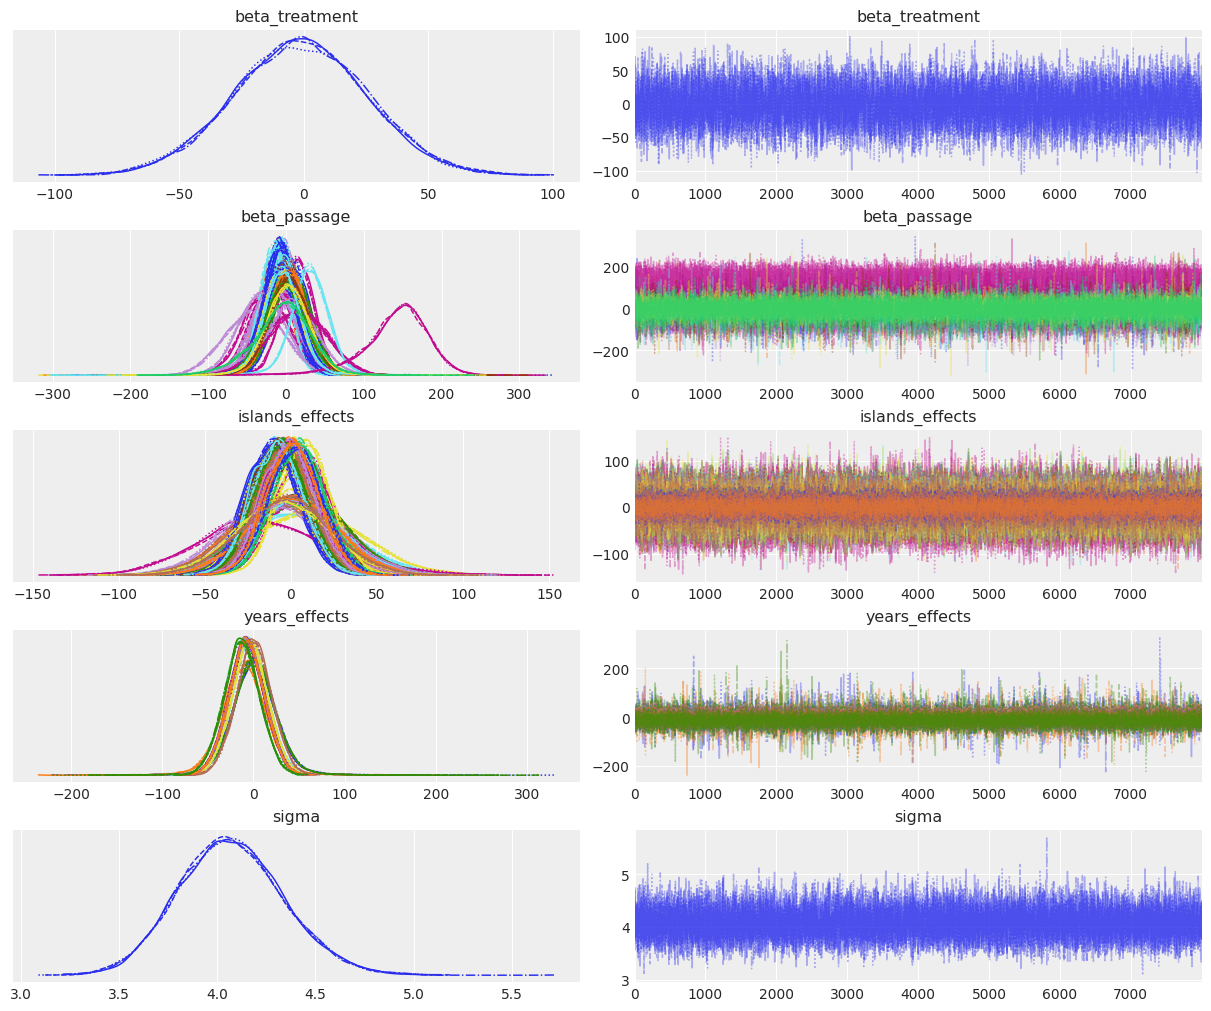

In [14]:
az.plot_trace(idata);

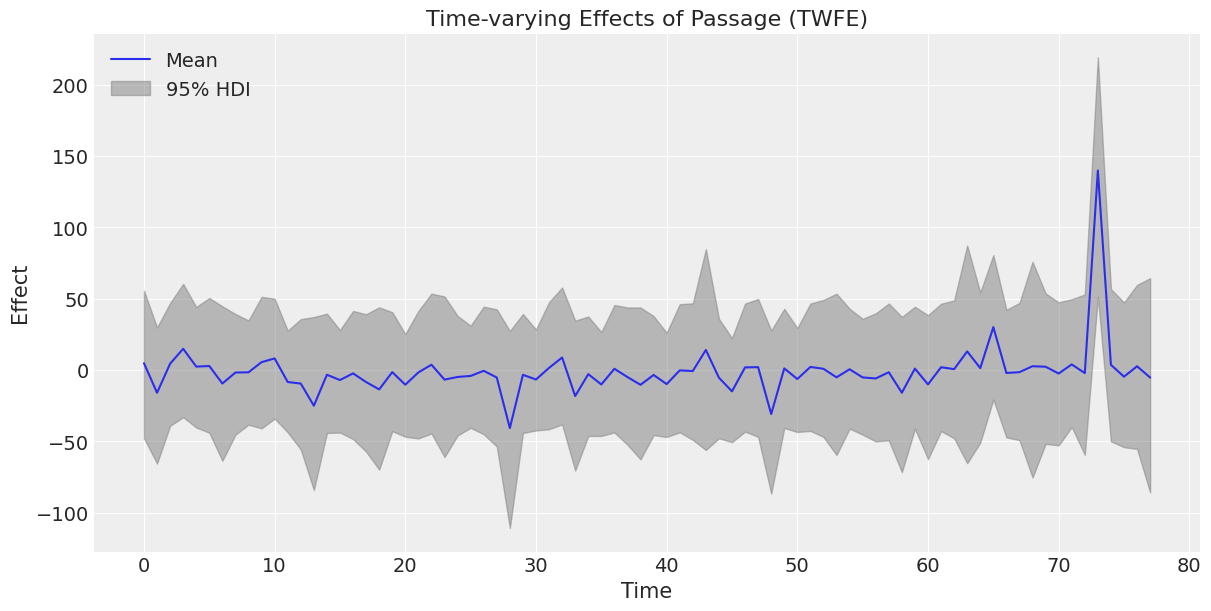

In [15]:
# beta_passageの事後分布を抽出
beta_passage_posterior = idata.posterior['beta_passage']

# 事後分布の平均と信用区間を計算
beta_passage_mean = beta_passage_posterior.mean(dim=["chain", "draw"]).values
beta_passage_hdi = az.hdi(beta_passage_posterior, hdi_prob=0.95)

# HDIの下限と上限を抽出
beta_passage_hdi_lower = beta_passage_hdi.sel(hdi='lower').to_array().values.flatten()
beta_passage_hdi_upper = beta_passage_hdi.sel(hdi='higher').to_array().values.flatten()

# プロットの作成
plt.figure(figsize=(12, 6))
plt.plot(beta_passage_mean, label='Mean')
plt.fill_between(
    range(len(beta_passage_mean)),
    beta_passage_hdi_lower,
    beta_passage_hdi_upper,
    color='gray', alpha=0.5, label='95% HDI'
)

plt.xlabel('Time')
plt.ylabel('Effect')
plt.title('Time-varying Effects of Passage (TWFE)')
plt.legend()
plt.show()

In [6]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')

In [16]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_passage'] > 0)
print(f"Pr(beta_passage > 0) = {prob_beta_bridge_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_passage > 0) = 0.4612
Pr(sigma > 0) = 1.0000


In [17]:
with model:
    pm.compute_log_likelihood(idata)

Output()

In [18]:
az.loo(idata)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 32000 posterior samples and 600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2406.60    29.29
p_loo      287.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      598   99.7%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    2    0.3%

In [42]:
az.waic(idata)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 32000 posterior samples and 600 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2418.06    30.99
p_waic      299.18        -

There has been a warning during the calculation. Please check the results.